In [46]:
import numpy as np
from math import sqrt
from scipy import stats
import os
from scipy import stats
import struct
import itertools
import time
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import eigh
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import scipy as sp
import math
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize
from skimage.transform import rescale
import png
import imageio
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets
import torch.nn.functional as f


def crop_center(img,cropy, cropx):
    y,x = img.shape
    return img[cropy:y-cropy,cropx:x-cropx]    

def imshow(img, size):
  plt.cla()
  plt.imshow(np.reshape(img, (size, size)), cmap='gray_r', vmin=0,vmax=1)
  plt.pause(0.001)
  plt.savefig("image.png")

def read_data(fname_root):
  fname_img = fname_root + "-images-idx3-ubyte"
  fname_lbl = fname_root + "-labels-idx1-ubyte"
  with open(fname_lbl, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    lbl = np.fromfile(flbl, dtype=np.int8)
  with open(fname_img, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)
  return img.astype(np.float32), lbl.astype(int)

def preprocess(x): return x/255

def save_image(x_save, y_save, size, location, x_prefix, data_description):
    if not os.path.exists(location):
        os.makedirs(location)        
    with open(location+'/'+x_prefix+'_desc.txt', 'w') as outfile:
        outfile.write(data_description);        
    with open(location+'/'+x_prefix+'_x_dump.json', 'w') as outfile:
        json.dump(x_save.tolist(), outfile);
    with open(location+'/'+x_prefix+'_y_dump.json', 'w') as outfile:
        json.dump(y_save.tolist(), outfile);
    plt.ioff()
    
    for i in range(np.size(x_save,0)):
        img = np.reshape(x_save[i,:],(size,size))
        plt.imshow(img, cmap='gray_r');
        plt.savefig(location+'/'+x_prefix+'_'+str(i)+'.png', bbox_inches='tight')
        plt.cla();
    plt.ion()
    
    
x_all, y_all = read_data("../datasets/raw/train")
x_test_all, y_test_all = read_data("../datasets/raw/t10k")
x_all, x_test_all = map(preprocess, [x_all, x_test_all])
n_classes = int(1 + np.max(y_all))
print("Data loaded")

#triplets = np.array([[0,1,5],[2,8,9],[3,6,7],[3,4,5]])
triplet = [0,1,5]

#for triplet in triplets:
print(triplet)
inds = (y_all==triplet[0]) + (y_all==triplet[1]) + (y_all==triplet[2]);
inds_test = (y_test_all == triplet[0]) + (y_test_all == triplet[1]) + (y_test_all == triplet[2]);

x,y = x_all[inds,:], y_all[inds];
x_test,y_test = x_test_all[inds_test,:], y_test_all[inds_test];

batch_size = 100
num_train = int(batch_size*np.floor(x.shape[0]/batch_size))
num_test = int(batch_size*np.floor(x_test.shape[0]/batch_size))

x,y = x[0:num_train,:], y[0:num_train]
x_test,y_test = x_test[0:num_test,:], y_test[0:num_test]

y[y==triplet[0]]=10;
y[y==triplet[1]]=11;
y[y==triplet[2]]=12;

y[y==10] = 0;
y[y==11] = 1;
y[y==12] = 2;

y_test[y_test==triplet[0]]=10;
y_test[y_test==triplet[1]]=11;
y_test[y_test==triplet[2]]=12;

y_test[y_test==10] = 0;
y_test[y_test==11] = 1;
y_test[y_test==12] = 2;

y_adv_target = (y+np.random.randint(1,3,np.shape(y)))%3
y_test_adv_target = (y_test+np.random.randint(1,3,np.shape(y_test)))%3

print(x.shape, y.shape, x_test.shape,y_test.shape)




dim1 = 15
isize = dim1**2

x_cropped = np.zeros((np.size(x,0),isize));
x_smooth = np.zeros((np.size(x,0),isize));
cur_perm = np.random.permutation(9)
for i in range(np.size(x,0)):
    img1 = crop_center(x[i,:].reshape(28,28), 3, 3)
    #img1_scaled = img1
    img1_scaled = rescale(img1, 15/22)
    img2_scaled = np.clip(2*gaussian_filter(img1_scaled,0.5),0,1);
    x_cropped[i,:] = img1_scaled.reshape(isize)
    x_smooth[i,:] = img2_scaled.reshape(isize)

x_cropped_test = np.zeros((np.size(x_test,0),isize));
x_smooth_test = np.zeros((np.size(x_test,0),isize));
for i in range(np.size(x_test,0)):
    img1 = crop_center(x_test[i,:].reshape(28,28), 3, 3)
    #img1_scaled = img1
    img1_scaled = rescale(img1, 15/22)
    img2_scaled = np.clip(2*gaussian_filter(img1_scaled,0.5),0,1);
    x_cropped_test[i,:] = img1_scaled.reshape(isize)
    x_smooth_test[i,:] = img2_scaled.reshape(isize)
    


zero_threshold = 0.1
x_smooth[x_smooth<=zero_threshold]=zero_threshold
x_smooth_test[x_smooth_test<=zero_threshold]=zero_threshold



random_seed = 0
np.random.seed(random_seed);
A = np.random.permutation(np.eye(isize));
x_rot = np.dot(x_smooth,A);
x_rot_test = np.dot(x_smooth_test,A);
x_rot_test_adv = np.copy(x_rot_test);

print("Data processing done")



Data loaded
[0, 1, 5]
(18000, 784) (18000,) (3000, 784) (3000,)


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Data processing done


In [49]:
print(x_rot_test_adv[2900:3000,:].shape)

(100, 225)


In [38]:
class PermutedMnistDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train):
        """
        Args:
           train (boolean): Whether to instantiate with train or test dataset
        """
        self.train = train
        if self.train==True:
            self.images = torch.from_numpy(np.reshape(x_rot,[-1,1,dim1,dim1])).float()
            #self.images = torch.from_numpy(np.reshape(x_smooth,[-1,1,dim1,dim1])).float()
            self.labels = torch.from_numpy(y)
            self.target_labels = torch.from_numpy(y_adv_target)
        else:
            self.images = torch.from_numpy(np.reshape(x_rot_test,[-1,1,dim1,dim1])).float()
            #self.images = torch.from_numpy(np.reshape(x_smooth_test,[-1,1,dim1,dim1])).float()
            self.labels = torch.from_numpy(y_test)
            self.target_labels = torch.from_numpy(y_test_adv_target)
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return (self.images[idx], self.labels[idx],self.target_labels[idx])
    
train_dataset = PermutedMnistDataset(train=True)
test_dataset = PermutedMnistDataset(train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
num_classes = 3
#batch_size = 100
learning_rate = 0.001



# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(5 * 5 * 64, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = ConvNet()
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []

print("Model setup done")

Model setup done


In [39]:
print("Starting training...")

for epoch in range(num_epochs):
    for i, (images, labels, _) in enumerate(train_loader):
        # Run the forward pass
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 90 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

            
print("Starting testing...")
            
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels,_ in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))



Starting training...
Epoch [1/10], Step [90/180], Loss: 0.0490, Accuracy: 99.00%
Epoch [1/10], Step [180/180], Loss: 0.0114, Accuracy: 100.00%
Epoch [2/10], Step [90/180], Loss: 0.0026, Accuracy: 100.00%
Epoch [2/10], Step [180/180], Loss: 0.0149, Accuracy: 99.00%
Epoch [3/10], Step [90/180], Loss: 0.0050, Accuracy: 100.00%
Epoch [3/10], Step [180/180], Loss: 0.0162, Accuracy: 99.00%
Epoch [4/10], Step [90/180], Loss: 0.0093, Accuracy: 100.00%
Epoch [4/10], Step [180/180], Loss: 0.0209, Accuracy: 99.00%
Epoch [5/10], Step [90/180], Loss: 0.0005, Accuracy: 100.00%
Epoch [5/10], Step [180/180], Loss: 0.0004, Accuracy: 100.00%
Epoch [6/10], Step [90/180], Loss: 0.0001, Accuracy: 100.00%
Epoch [6/10], Step [180/180], Loss: 0.0643, Accuracy: 99.00%
Epoch [7/10], Step [90/180], Loss: 0.0003, Accuracy: 100.00%
Epoch [7/10], Step [180/180], Loss: 0.0000, Accuracy: 100.00%
Epoch [8/10], Step [90/180], Loss: 0.0002, Accuracy: 100.00%
Epoch [8/10], Step [180/180], Loss: 0.0050, Accuracy: 100.00%


In [31]:
print("Starting adversarial training...")

rob_thold = 0.2
lrate_adv = 4e-2



for epoch in range(num_epochs):
    for i, (images, labels,_) in enumerate(train_loader):
        # Run the forward pass
        images, labels = images.to(device), labels.to(device)
        images_original = images.clone()

        for j in range(10):
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            with torch.no_grad():
                images_grad_step = lrate_adv*torch.sign(images.grad)

                #Take grad step
                images += images_grad_step

                #Project
                images = images_original + torch.clamp(images-images_original, -rob_thold, rob_thold)
                images = torch.clamp(images,0.1,1)
        
        images.requires_grad = False
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 90 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

print("Starting testing...")
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels,_ in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Starting adversarial training...
Epoch [1/10], Step [90/180], Loss: 0.6763, Accuracy: 75.00%
Epoch [1/10], Step [180/180], Loss: 0.4264, Accuracy: 78.00%
Epoch [2/10], Step [90/180], Loss: 0.5101, Accuracy: 74.00%
Epoch [2/10], Step [180/180], Loss: 0.4739, Accuracy: 79.00%
Epoch [3/10], Step [90/180], Loss: 0.3866, Accuracy: 85.00%
Epoch [3/10], Step [180/180], Loss: 0.5084, Accuracy: 79.00%
Epoch [4/10], Step [90/180], Loss: 0.3687, Accuracy: 87.00%
Epoch [4/10], Step [180/180], Loss: 0.2064, Accuracy: 90.00%
Epoch [5/10], Step [90/180], Loss: 0.2308, Accuracy: 95.00%
Epoch [5/10], Step [180/180], Loss: 0.3326, Accuracy: 90.00%
Epoch [6/10], Step [90/180], Loss: 0.3741, Accuracy: 88.00%
Epoch [6/10], Step [180/180], Loss: 0.2678, Accuracy: 88.00%
Epoch [7/10], Step [90/180], Loss: 0.3221, Accuracy: 88.00%
Epoch [7/10], Step [180/180], Loss: 0.2368, Accuracy: 91.00%
Epoch [8/10], Step [90/180], Loss: 0.3204, Accuracy: 87.00%
Epoch [8/10], Step [180/180], Loss: 0.3012, Accuracy: 88.00%

In [51]:
print("Starting adversarial testing")

# Test the model on adversrial examples
from torch.autograd import Variable

for param in model.parameters():
    param.requires_grad=False

rob_thold = 0.2
lrate_adv = 4e-2



model.eval()

correct = 0
total = 0


count = 0
for images, labels,target_labels in test_loader:
    print(count)        
    count+=batch_size
    images, labels,target_labels = images.to(device), labels.to(device), target_labels.to(device)
    images_original = images.clone()
    
    for i in range(50):
        #print(i)
        images.requires_grad = True
        outputs = model(images)
        #loss = criterion(outputs, labels)
        #loss.backward()
        inds_output = np.arange(batch_size)
        outputs_sum = torch.sum(outputs[inds_output,target_labels])
        outputs_sum.backward()

        with torch.no_grad():
            
            ##l-inf attack
            images_grad_step = lrate_adv*torch.sign(images.grad)
            
            #Take grad step
            images += images_grad_step
            
            #Project
            images = images_original + torch.clamp(images-images_original, -rob_thold, rob_thold)
            images = torch.clamp(images,0.1,1)
            ##l-inf attack ends
        

            
    outputs = model(images)
    #print(count, count+batch_size,np.shape(x_rot_test_adv[count:count+batch_size,:]))
    x_rot_test_adv[count-batch_size:count,:] = np.reshape(images.cpu().numpy(),(batch_size,dim1*dim1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

Starting1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Test Accuracy of the model on the test images: 15.333333333333332 %


In [76]:
x_smooth_test_noisy = x_smooth_test+np.random.randint(0,2,x_smooth_test.shape)*rob_thold*2 - rob_thold
x_smooth_test_noisy[x_smooth_test_noisy<=zero_threshold]=zero_threshold
x_rot_test_noisy = np.dot(x_smooth_test_noisy,A)
x_smooth_test_adv = np.dot(x_rot_test_adv, A.T)

save_size = 1000

np.savez('gen_data/temp',x_smooth[0:save_size,:],x_smooth_test[0:save_size,:],x_smooth_test_noisy[0:save_size,:],x_smooth_test_adv[0:save_size,:],x_rot[0:save_size,:],x_rot_test[0:save_size,:],x_rot_test_noisy[0:save_size,:],x_rot_test_adv[0:save_size,:],y[0:save_size],y_test[0:save_size],y_test_adv_target[0:save_size],random_seed)

#tt=np.load('gen_data/temp.npz')

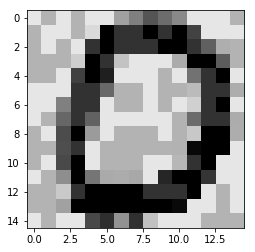

0


In [115]:
imshow(tt['arr_2'][4,:],15)
print(tt['arr_9'][4])

In [63]:
#imshow(x_rot_test_adv[2,:].dot(A.T),15)
#plt.imshow(images[-1,0,:,:].cpu().numpy().reshape(isize).dot(A.T).reshape((15,15)), vmin=0, vmax=1, cmap='gray_r')
#plt.imshow(images[-1,0,:,:].cpu().numpy(), vmin=0, vmax=1, cmap='gray_r')
#print(y_test[2],y_test_adv_target[2])
#print(outputs[1:10])

print(np.min(x_rot_test_adv))

#print(outputs[[1,2,3],labels[1:3]])


0.10000000149011612


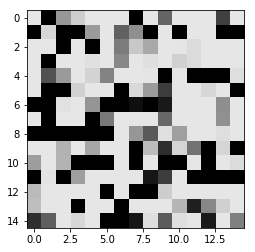

In [85]:
imshow(x_rot_test[4,:],15)

In [ ]:
print('training svm model...')        

#Choice of C makes a big difference sometimes
model = svm.LinearSVC(max_iter = 5e3,C=0.001)

model.fit(x_smooth,y)
y_test_pred = model.predict(x_smooth_test)
y_train_pred = model.predict(x_smooth);
print('Train error = ', np.mean(y_train_pred!=y))
print('Test error = ', np.mean(y_test_pred!=y_test))

coefs = model.coef_;
eps = 0.2;
train_set = x_smooth[0:1000,:];
test_set = x_smooth_test[0:1000,:];
y_train_set = y[0:1000];
y_test_set = y_test[0:1000];

rot_train_set = x_rot[0:1000,:];
rot_test_set = x_rot_test[0:1000,:];

normal_noise = np.random.randint(0,2,np.shape(rot_test_set))*eps*2 - eps;
test_set_noisy = np.clip(test_set + normal_noise,0,1);
rot_test_set_noisy = np.dot(test_set_noisy ,A);

y_adv_target = np.zeros(1000);
test_set_adv = np.zeros(np.shape(test_set));

for i in range(1000):
    label = y_test_set[i];
    if label==0:
        target_label = np.random.randint(1,3)                
    elif label == 1:
        target_label = np.random.randint(0,2)*2;
    elif label==2:
        target_label = np.random.randint(0,2);
    else:
        print("error! undefined label.")
    #print('before:',human_perf[co,3])
    y_adv_target[i] = target_label;

    test_set_adv[i,:] = np.clip(test_set[i,:] + np.sign(coefs[target_label,:])*eps,0,1);

rot_test_set_adv = np.dot(test_set_adv ,A);

parent_dir = 'images_smooth/labels_'+str(triplet[0])+str(triplet[1])+str(triplet[2])+'/perm'+str(random_seed);


save_image(train_set, y_train_set, 15, parent_dir+'/normal/train', 'train', 'Training data, normal images, 15 X 15');
print('Done');
save_image(test_set, y_test_set, 15, parent_dir+'/normal/test', 'test', 'Test data, normal images, 15 X 15');
print('Done');
save_image(test_set_noisy, y_test_set, 15, parent_dir+'/normal/test_noisy', 'test_noisy', 'Test data with +-0.2 noise, normal images, 15 X 15');
print('Done');
save_image(test_set_adv, y_adv_target, 15, parent_dir+'/normal/test_adv', 'test_adv', 'Test data with linf 0.2 adversarial noise, normal images, 15 X 15, y dump contains target y label');
print('Done');

save_image(rot_train_set, y_train_set, 15, parent_dir+'/rotated/train', 'train', 'Training data, rotated images, 15 X 15');
print('Done');
save_image(rot_test_set, y_test_set, 15, parent_dir+'/rotated/test', 'test', 'Test data, rotated images, 15 X 15');
print('Done');
save_image(rot_test_set_noisy, y_test_set, 15, parent_dir+'/rotated/test_noisy', 'test_noisy', 'Test data with +-0.2 noise, rotated images, 15 X 15');
print('Done');
save_image(rot_test_set_adv, y_adv_target, 15, parent_dir+'/rotated/test_adv', 'test_adv', 'Test data with linf 0.2 adversarial noise, rotated images, 15 X 15, y dump contains target y label');
print('Done');

